In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("file.csv")
data = data.drop([data.columns[0]], axis=1)
data.values[:5].tolist()

[['ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI',
  'neutral'],
 ['Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr',
  'good'],
 ['ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\\n\\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34',
  'neutral'],
 ['THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71',
  'good'],
 ['As of 2 minutes ago, @OpenAI released their new ChatGPT. \\n\\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1',
  'bad']]

In [ ]:
data.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


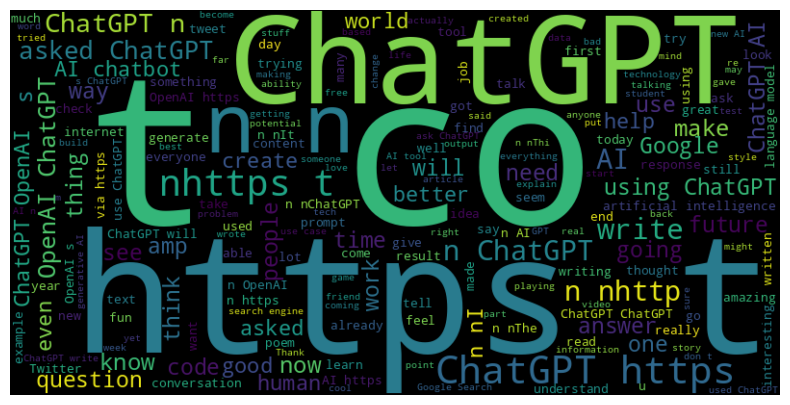

In [ ]:
from wordcloud import WordCloud

text_data = data['tweets'].str.cat(sep=' ')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(text_data)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print("Duplicated values: " , data.duplicated().sum())

data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

Duplicated values:  1671
<class 'pandas.core.frame.DataFrame'>
Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


In [ ]:
data["labels"].value_counts()

labels
bad        106695
good        55754
neutral     55174
Name: count, dtype: int64

In [ ]:
class_0 = data[data["labels"] == "neutral"]
class_1 = data[data["labels"] == "good"]
class_neg = data[data["labels"] == "bad"]
class_neg  = class_neg.iloc[:70000]
data = pd.concat([class_neg , class_0 , class_1])

data.head()

,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
6,"As of 2 minutes ago, @OpenAI released their ne...",bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,bad
17,#ai Models are set to become the search engine...,bad
39,Google is done.\n\nCompare the quality of thes...,bad


In [ ]:
data["labels"].value_counts()

labels
bad        70000
good       55754
neutral    55174
Name: count, dtype: int64

In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False

    return True

def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    #words = [st.stem(word) for word in words]
    words = [lem.lemmatize(word) for word in words]

    # text = " ".join([word for word in text.split(" ") if is_alpha(word)])
    # text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    words = [w for w in words if not w in stop_words]
    text = " ".join(words)

    return text.strip()

data.insert(len(data.columns)-1, "cleaned_tweets", data['tweets'].apply(clean_dataset))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweets,cleaned_tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,bad
17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,bad
39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,bad


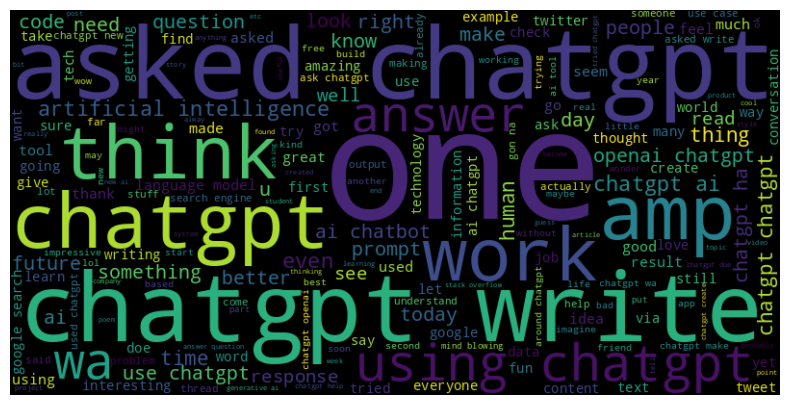

In [ ]:
from wordcloud import WordCloud

text_data = data['cleaned_tweets'].str.cat(sep=' ')

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(text_data)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Encoded the target column
lb=LabelEncoder()
data['labels'] = lb.fit_transform(data['labels'])

In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data['cleaned_tweets'].values)
X = tokenizer.texts_to_sequences(data['cleaned_tweets'].values)
X = pad_sequences(X)

# LSTM

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 120)           60000     
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 120)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269619 (1.03 MB)
Trainable params: 269619 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
#Splitting the data into training and testing
y=pd.get_dummies(data['labels'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
from keras.callbacks import EarlyStopping
history = model.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/10
112/112 [==============================] - 153s 1s/step - loss: 0.8789 - accuracy: 0.5923 - val_loss: 0.7326 - val_accuracy: 0.7086
Epoch 2/10
112/112 [==============================] - 147s 1s/step - loss: 0.7366 - accuracy: 0.7065 - val_loss: 0.7125 - val_accuracy: 0.7150
Epoch 3/10
112/112 [==============================] - 147s 1s/step - loss: 0.7247 - accuracy: 0.7120 - val_loss: 0.7046 - val_accuracy: 0.7199
Epoch 4/10
112/112 [==============================] - 150s 1s/step - loss: 0.7151 - accuracy: 0.7153 - val_loss: 0.6966 - val_accuracy: 0.7233
Epoch 5/10
112/112 [==============================] - 147s 1s/step - loss: 0.7059 - accuracy: 0.7188 - val_loss: 0.6931 - val_accuracy: 0.7270
Epoch 6/10
112/112 [==============================] - 147s 1s/step - loss: 0.7001 - accuracy: 0.7207 - val_loss: 0.6890 - val_accuracy: 0.7264
Epoch 7/10
112/112 [==============================] - 149s 1s/step - loss: 0.6957 - accuracy: 0.7217 - val_loss: 0.6860 - val_accuracy: 0.7278

In [ ]:
model.evaluate(X_test,y_test)

1697/1697 [==============================] - 35s 21ms/step - loss: 0.6888 - accuracy: 0.7263


[0.6888452172279358, 0.7262845635414124]

In [ ]:
predicted_labels = model.predict(X_test, verbose=1)

1697/1697 [==============================] - 33s 19ms/step


In [ ]:
def predict_user_input(tweets , model):
    data = pd.DataFrame({ 'Tweets': tweets })
    cleaned_data = data['Tweets'].apply(clean_dataset)
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    pad_seqs = pad_sequences(sequences)
    predicted_labels = model.predict(pad_seqs)
    data['labels'] = [ lb.classes_[label_num] for label_num in np.argmax(predicted_labels, axis=1)]
    #print(data)
    return predicted_labels, data

def userIn(model):
    x=input("enter sentence or x for exit: ")
    while x != "x":
        predict_user_input([x] , model)
        x=input("enter sentence or x for exit: ")

userIn(model)

enter sentence or x for exit: chat gpt is very very good
1/1 [==============================] - 0s 49ms/step
[[0.05852327 0.52592546 0.41555125]]
enter sentence or x for exit: chatGpt is good
1/1 [==============================] - 0s 25ms/step
[[0.05360608 0.6403863  0.30600768]]
enter sentence or x for exit: x


In [ ]:
y_test.dtypes

0    bool
1    bool
2    bool
dtype: object

In [ ]:
from sklearn.metrics import classification_report

# Convert predicted labels back to original classes
predicted_labels_classes = [np.argmax(label) for label in predicted_labels]
y_test_classes = [np.argmax(label) for label in y_test.values]

# Generate classification report
report = classification_report(y_test_classes, predicted_labels_classes, target_names=lb.classes_)
print(report)

              precision    recall  f1-score   support

         bad       0.72      0.89      0.79     20852
        good       0.82      0.70      0.75     17037
     neutral       0.65      0.55      0.60     16390

    accuracy                           0.73     54279
   macro avg       0.73      0.71      0.71     54279
weighted avg       0.73      0.73      0.72     54279



# Random Forest

In [ ]:
y=pd.get_dummies(data['labels'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Train the Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

# Evaluate the model
y_pred = random_forest_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=lb.classes_)
print(report)

              precision    recall  f1-score   support

         bad       0.74      0.53      0.62     20852
        good       0.63      0.38      0.48     17037
     neutral       0.69      0.24      0.35     16390

   micro avg       0.69      0.40      0.50     54279
   macro avg       0.69      0.38      0.48     54279
weighted avg       0.69      0.40      0.49     54279
 samples avg       0.40      0.40      0.40     54279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

print("Accuracy : ",accuracy)
print("Precision : ",precision)
print('Recall : ',recall)

Accuracy :  0.39549365316236484
Precision :  0.6907783641322858
Recall :  0.39549365316236484


# Naive Bayes

In [ ]:
#Splitting the data into training and testing
y=data['labels']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [ ]:
nb.fit(X_train,y_train)

MultinomialNB()

In [ ]:
pred=nb.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred, target_names=lb.classes_))

              precision    recall  f1-score   support

         bad       0.47      0.83      0.60     20852
        good       0.53      0.36      0.43     17037
     neutral       0.34      0.12      0.18     16390

    accuracy                           0.47     54279
   macro avg       0.44      0.43      0.40     54279
weighted avg       0.45      0.47      0.42     54279

